In [1]:
import single_globule

In [19]:
single_globule.Flow.Umax = 5.0
flow = single_globule.Flow()

In [20]:
flow.radial_density_histogram(flow.R_edges, flow.density_edges, nbins=30)

(array([3.55984086, 1.9627828 , 1.63817352, 1.52681409, 1.35610373,
        1.31660017, 1.23115608, 1.17492971, 1.1673998 , 1.0681781 ,
        1.10871795, 0.97953486, 1.00297041, 1.02215533, 0.94932783,
        0.95602401, 0.86988046, 0.86506571, 0.76921094, 0.83747002,
        0.73130954, 0.70243957, 0.66499409, 0.55165344, 0.56577939,
        0.49488386, 0.36789397, 0.28700819, 0.20793539, 0.06376617]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]))

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns

(0.0, 5.2)

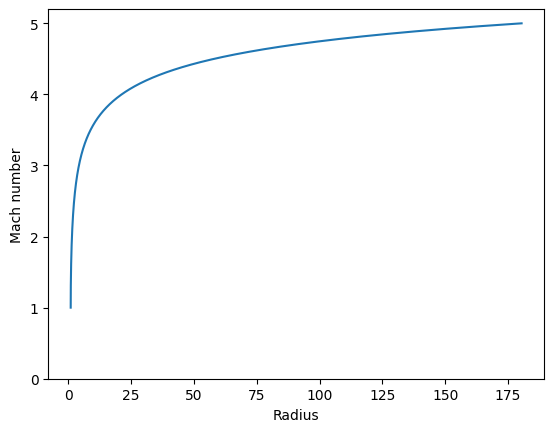

In [22]:
fig, ax = plt.subplots()
ax.plot(flow.R_edges, flow.U_edges)
ax.set_xlabel("Radius")
ax.set_ylabel("Mach number")
ax.set_ylim(0, None)

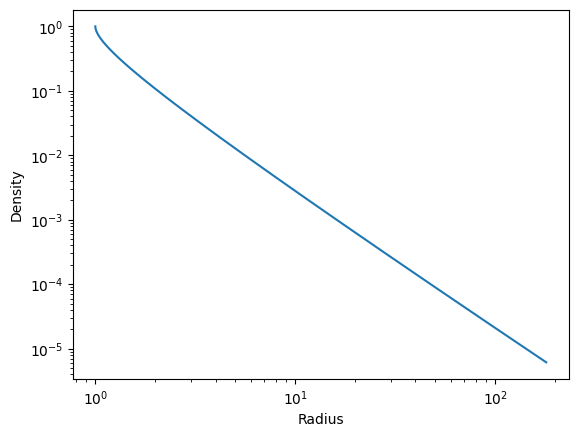

In [23]:
fig, ax = plt.subplots()
ax.plot(flow.R_edges, flow.density_edges)
ax.set_xlabel("Radius")
ax.set_ylabel("Density")
# ax.set_ylim(None, None)
ax.set_xscale("log")
ax.set_yscale("log")


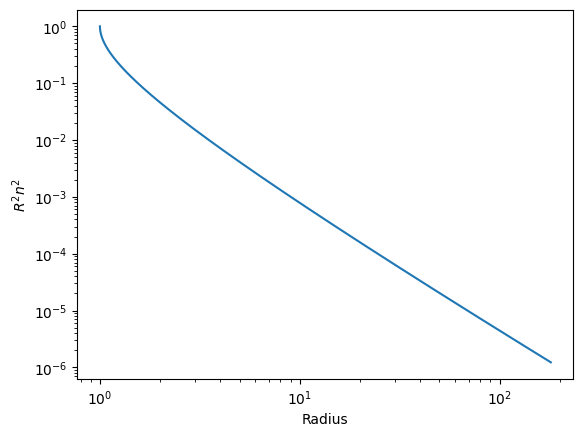

In [37]:
fig, ax = plt.subplots()
ax.plot(flow.R_edges, flow.R_edges**2 * flow.density_edges**2)
ax.set_xlabel("Radius")
ax.set_ylabel("$R^2 n^2$")
# ax.set_ylim(None, None)
ax.set_xscale("log")
ax.set_yscale("log")


## Test the integration of emissivity

In [ ]:
np.trapzd(flow.R_edges

In [17]:
flow.alpha

2.0

In [24]:
radii, densities = flow.R_edges, flow.density_edges

In [27]:
import numpy as np

In [28]:
radii_centers = 0.5 * (radii[:-1] + radii[1:])
volume_elements = radii_centers**flow.alpha * np.diff(radii)
density_centers = 0.5 * (densities[:-1] + densities[1:])
weights = density_centers**2 * volume_elements


In [33]:
radii_centers

array([8.00538937e-06, 2.39741390e-05, 3.98809816e-05, 5.57274152e-05,
       7.15149164e-05, 8.72449411e-05, 1.02918925e-04, 1.18538283e-04,
       1.34104411e-04, 1.49618688e-04, 1.65082471e-04, 1.80497100e-04,
       1.95863900e-04, 2.11184175e-04, 2.26459213e-04, 2.41690288e-04,
       2.56878654e-04, 2.72025553e-04, 2.87132209e-04, 3.02199832e-04,
       3.17229618e-04, 3.32222746e-04, 3.47180385e-04, 3.62103687e-04,
       3.76993791e-04, 3.91851825e-04, 4.06678903e-04, 4.21476126e-04,
       4.36244583e-04, 4.50985353e-04, 4.65699499e-04, 4.80388078e-04,
       4.95052133e-04, 5.09692695e-04, 5.24310788e-04, 5.38907422e-04,
       5.53483600e-04, 5.68040313e-04, 5.82578543e-04, 5.97099263e-04,
       6.11603438e-04, 6.26092020e-04, 6.40565957e-04, 6.55026186e-04,
       6.69473635e-04, 6.83909227e-04, 6.98333875e-04, 7.12748483e-04,
       7.27153950e-04, 7.41551166e-04, 7.55941015e-04, 7.70324373e-04,
       7.84702110e-04, 7.99075090e-04, 8.13444168e-04, 8.27810195e-04,
      